## Classification
__Note:__ 
- Running this notebook requires extracting the audio features and processing the states via  _Feature Extraction.ipynb_
<br><br>

Aircraft/nonaircraft classification is done using the __Classification__ class. This class expects the root directory of the dataset and, optionally, non-default parameters for spectrum-, feature-, and state settings. This notebook classifies the noisy Mel spectra, then evaluates performance in the mismatched conditions caused by reducing MAV ego-noise.
<br><br>
The network used is a __convolutional neural network__ with two inputs: 
- 3 convolutional layers and 2 fully-connected layers for input 1 (spectra)
- 2 fully-connected layers for input 2 (states)
<br><br>

Network configuration and training settings are passed to the class through dictionaries containing the appropriate _torch.nn_ attributes.<br><br>

In [1]:
import os

import aircraft_detector.aircraft_classification.classification as cla


# assign root directory
root_directory = os.path.join(os.pardir, os.pardir, os.pardir, 'Data')

# load the settings: 
    # many of these are default settings, but are loaded explicitly for transparency
# spectrum settings of previously extracted set
spectrum_settings = {
    'feature': 'Mel',  # default = 'Stft'
    'fft_sample_rate': 44100,  # default
    'stft_window_length': 1024,  # default
    'stft_hop_length': 512,  # default
    'frequency_bins': 60,  # default
}
# feature settings: used to split up the (5 second/431 frames) spectra
feature_settings = {
    'segment_frames': 60,  # frames per segment (default: 60), approx. 70ms
    'segment_hop': 30,  # hop length per segment (default: 30), approx. 35ms
    'frequency_smoothing': True,  # smooth each spectrum in frequency (default: True)
    'use_delta': True,  # extract time derivate of spectrum as second channel (default: True)
}
# classification settings: how to load the dataset
classification_settings = {
    'binary': True,  # do binary classification (default: True)
    'aircraft': ['airplane', 'helicopter'],  # designated aircraft classes (default if binary)
    'nonaircraft': ['engine', 'train', 'wind'],  # nonaircraft classes (default if binary)
    'balanced_split': True,  # use a balanced split (default if binary)
    'balance_ratios': [0.2, 0.2, 0.6]  # balance ratios of 'larger' class (nonaircraft),
                                       # overflow in ratios is automatically corrected
}

# load class with settings
classifier = cla.AircraftClassifier(
    root_directory, 
    spectrum_settings=spectrum_settings, 
    feature_settings=feature_settings,
    classification_settings=classification_settings,
    implicit_denoise=True  # denoise and classify in one
)
classifier.verbose = True
classifier.super_verbose = False  # print every epoch (default: False)

In [2]:
# split noisy spectra into 60x60 features, export them
classifier.split_features(augmentations=[], noise_set='Mixed', noise_ratio=1.0)  # no augmentation

# load features
df = classifier.load_datasets()  # dataframe listing files, categories and labels

Split 40 files (5 categories) into 499 files
Split 125 files (5 categories) into 1604 files
Split 35 files (5 categories) into 450 files


In [3]:
"""
Set the model configuration (list of layers): the first entry
    {'layer_type': 'Conv2d', 'out_channels': 16, 'kernel_size': (5, 5), 'dilation': (2, 2)} 
    is equivalent to 
    torch.nn.Conv2d(in_channels=2, out_channels=16, kernel_size=(5, 5), dilation=(2, 2));
    input_size is derived from the dataset.
    From thereon, in_channels or in_features is derived from the previous layer.
    'Linear_2' indicates a Linear layer belonging to the second input (states).
    By default, a linear output layer is added at the end:
        torch.nn.Linear(in_features=32, out_features=1).
"""
# 'location' in BatchNorm2d indicates if it should be before or after ReLU (default: before)
bn_location = 'before'
config = [
    {'layer_type': 'Conv2d', 'out_channels': 16, 'kernel_size': (5, 5), 'dilation': (2, 2)},
    {'layer_type': 'BatchNorm2d', 'location': bn_location, 'momentum': 0.1},
    {'layer_type': 'MaxPool2d', 'kernel_size': (2, 2)},
    {'layer_type': 'Conv2d', 'out_channels': 16, 'kernel_size': (5, 5), 'dilation': (2, 2)},
    {'layer_type': 'BatchNorm2d', 'location': bn_location, 'momentum': 0.1},
    {'layer_type': 'MaxPool2d', 'kernel_size': (2, 2)},
    {'layer_type': 'Conv2d', 'out_channels': 32, 'kernel_size': (5, 5)},
    {'layer_type': 'BatchNorm2d', 'location': bn_location, 'momentum': 0.1},
    {'layer_type': 'Linear_2', 'out_features': 200},
    {'layer_type': 'Dropout', 'p': 0.2},
    {'layer_type': 'Linear_2', 'out_features': 200},
    {'layer_type': 'Dropout', 'p': 0.5},
    {'layer_type': 'Linear', 'out_features': 128},
    {'layer_type': 'Dropout', 'p': 0.5},
    {'layer_type': 'Linear', 'out_features': 32},
    {'layer_type': 'Dropout', 'p': 0.5},
]
classifier.set_net_configuration(config)

# set the training configuration
# equivalent to torch.optimizer.Adamw(lr=0.0001, weight_decay=0.01, amsgrad=False)
optimizer = {'optimizer': 'AdamW', 'lr': 0.0001, 'weight_decay': 0.01, 'amsgrad': False}
train_settings = {
    'epochs': 100, 
    'es_patience': 25,  # early stopping patience
    'batch_size': 256,
    'optimizer': optimizer,
}

Device: cuda.
Number of trainable parameters in network: 516881.


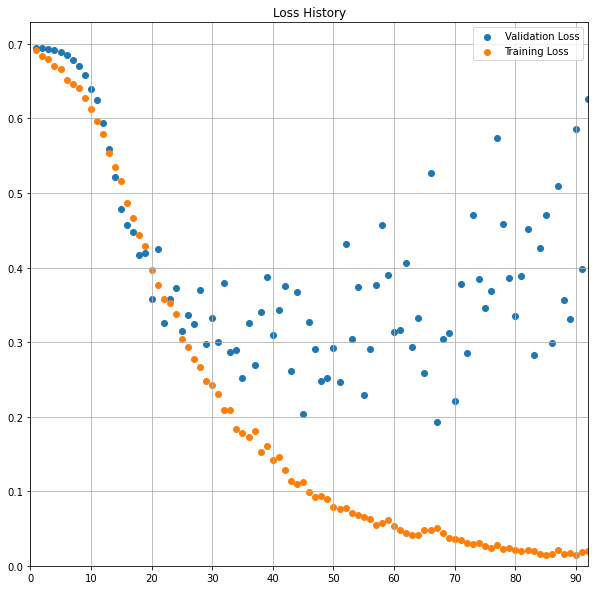

Training loss: 0.050850, Validation loss: 0.192846, Test loss: 0.301689.


/home/mark/Documents/Thesis/Article/aircraft_detector/aircraft_detector/aircraft_classification/classification.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["Predicted"] = predictions
/home/mark/Documents/Thesis/Article/aircraft_detector/aircraft_detector/aircraft_classification/classification.py:614: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["Predicted"] = dataframe["Predicted"].round(4)


,overall,airplane,helicopter,engine,train,wind
1.00,89.9% (95%),84.6% (100%),88.4% (87.5%),100%,93.6% (87.5%),90.4% (100%)


In [9]:
from aircraft_detector.utils.plot_helper import plot_training_history


# train model
model, train_losses, loss_history = classifier.train_network(train_settings)
train_loss, val_loss = train_losses

# plot training history
plot_training_history(loss_history)

# test model
test_loss = classifier.test_network(model)

# get accuracy
df_out = classifier.classify_dataset(model, 'Test', df)  # adds 'Predicted' to dataframe
df_log = classifier.log_accuracy(df_out, index_name='1.00')  # log accuracy
#accuracies = classifier.print_accuracy(df_out)
#print("Segment-based accuracy: %.3f%%." % accuracies[0])  # should be around 95%
#print("Recording-based accuracy: %.3f%%." % accuracies[1])  # should be 97.5%
print("Training loss: %.6f, Validation loss: %.6f, Test loss: %.6f."
     % (train_loss, val_loss, test_loss)) 
df_log

/home/mark/anaconda3/envs/thesis/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/mark/anaconda3/envs/thesis/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


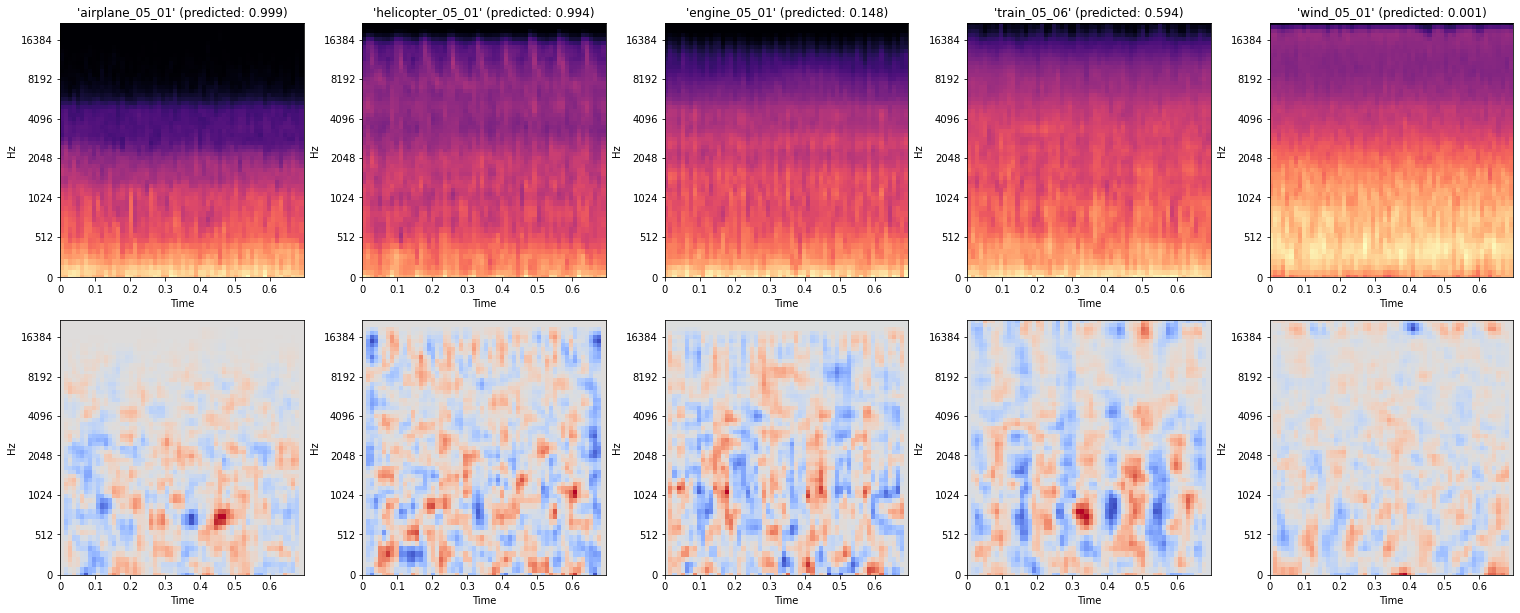

In [10]:
# plot some example predictions
fig = classifier.plot_predictions(df_out, plot_title='prediction')

In [6]:
# save the model
#dir_network = classifier.save_network(model, test_loss)

# load the model
#model, dir_model = classifier.load_network()


Split 40 files (5 categories) into 499 files
Split 40 files (5 categories) into 499 files
Split 40 files (5 categories) into 499 files


,overall,airplane,helicopter,engine,train,wind
1.00,89.9% (95%),84.6% (100%),88.4% (87.5%),100%,93.6% (87.5%),90.4% (100%)
0.75,81.4% (90%),78.8% (100%),85.3% (87.5%),93.8% (87.5%),93.6% (100%),69.2% (75%)
0.50,74.4% (77.5%),76.9% (75%),86.3% (87.5%),89.6% (87.5%),93.6% (87.5%),45.2% (50%)
0.25,71.4% (75%),66.3% (75%),83.2% (87.5%),93.8% (87.5%),97.9% (87.5%),43.3% (37.5%)


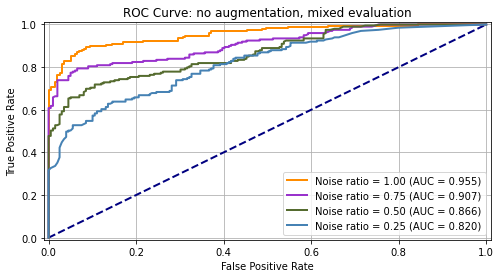

In [11]:
from aircraft_detector.utils.plot_helper import plot_roc


# evaluate in mismatched conditions
augmentation = 'No'
colors = ['darkorchid', 'darkolivegreen', 'steelblue', 'goldenrod']  # looks better than rgby

# plot matching ROC
fig_title = "ROC Curve: %s augmentation, mixed evaluation" % augmentation.lower()
plt_label = "Noise ratio = 1.00"
fig = plot_roc(
    df_out['Label'], df_out['Predicted'], title=fig_title, label=plt_label
)

# plot mismatched ROC
for i, noise_ratio in enumerate([0.75, 0.50, 0.25]):
    # split evaluation set into 60x60 features
    classifier.split_features('Test', noise_set='Mixed', noise_ratio=noise_ratio)
    # evaluate on segments (noisy)    
    df_mismatched = classifier.classify_mismatched_test_set(model)

    # add to log
    df_log = classifier.log_accuracy(df_mismatched, df_log, '%.2f' % noise_ratio)

    # print accuracies
    #print("Accuracy for 'Mixed' with noise ratio = %.2f:" % noise_ratio)
    #accuracies = classifier.print_accuracy(df_noisy)

    # add to ROC plot
    plt_label = "Noise ratio = %.2f" % noise_ratio
    plot_roc(
        df_mismatched['Label'], 
        df_mismatched['Predicted'],
        fig=fig,
        label=plt_label, 
        color=colors[i]
    )
# save the plot
#fig_dest = 'ROC_%s_%s.eps' % (augmentation.replace(' ', '').lower(), noise_set.lower())
#fig.savefig(fig_dest, format='eps')

# save the results
#df_log.to_csv('%s_results.csv' % augmentation.replace(' ', '').lower())

df_log
